## 이미지 벡터DB에 저장 및 호출

## Pre-requisites

In [4]:
!pip install langchain_experimental 

In [5]:
!pip install open_clip_torch torch

In [6]:
!pip install chromadb

## Preparing image folder

In [7]:
import os
from pathlib import Path

import pypdfium2 as pdfium


def get_images(file):
    """
    Get PIL images from PDF pages and save them to a specified directory
    :param file: Path to file
    :return: A list of PIL images
    """

    # Get presentation
    pdf = pdfium.PdfDocument(file)
    n_pages = len(pdf)

    # Extracting file name and creating the directory for images
    file_name = Path(file).stem  # Gets the file name without extension
    img_dir = os.path.join(Path(file).parent, "img") #img라는 폴더 만들기
    os.makedirs(img_dir, exist_ok=True)

    # Get images, 각 pdf 페이지를 이미지로 저장하기 위해, 페이지 번호를 이름 뒤에 추가한 후에 img 폴더에 저장함
    pil_images = []
    print(f"Extracting {n_pages} images for {file_name}")
    for page_number in range(n_pages):
        page = pdf.get_page(page_number)
        bitmap = page.render(scale=1, rotation=0, crop=(0, 0, 0, 0))
        pil_image = bitmap.to_pil()
        pil_images.append(pil_image)

        # Saving the image with the specified naming convention
        image_path = os.path.join(img_dir, f"{file_name}_image_{page_number + 1}.jpg")
        pil_image.save(image_path, format="JPEG")

    return pil_images

file_names = ["example.pdf", "example2.pdf"]

images = []
for fi in file_names:
    images.extend(get_images(fi))

Extracting 127 images for example
Extracting 127 images for example2


In [8]:
# Convert PIL images into resized base64 string

import base64
import io
from io import BytesIO

from PIL import Image


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string

    :param base64_string: Base64 string
    :param size: Image size
    :return: Re-sized Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    img_str = resize_base64_image(img_str, size=(960, 540))
    return img_str


images_base_64 = [convert_to_base64(i) for i in images]

In [9]:
images_base_64[126]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIcA8ADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAo


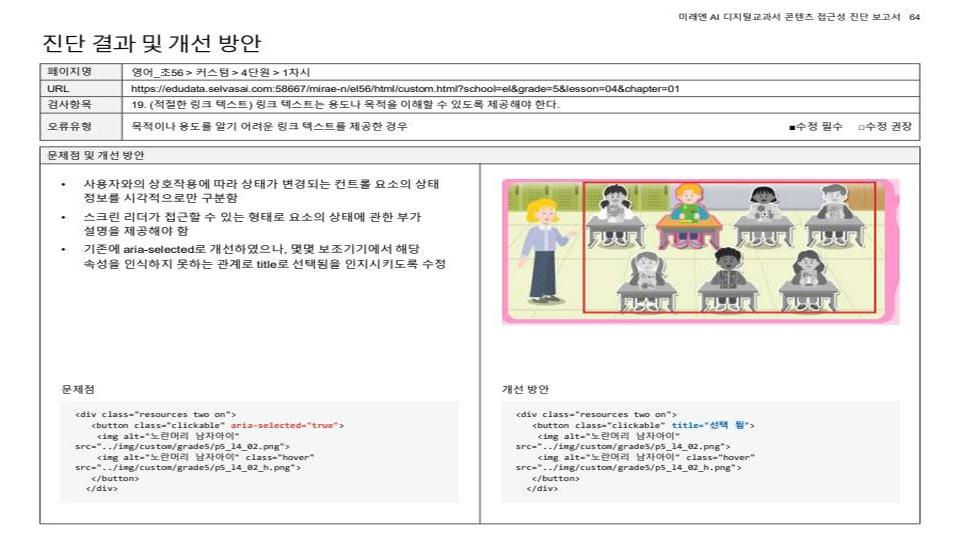

In [10]:
# Plot the images

from IPython.display import HTML, display


def plt_img_base64(img_base64):
    """
    Disply base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


i = 189
plt_img_base64(images_base_64[i])

## Vectorstore with multimodal embedding

In [11]:
from langchain.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings

# Make vectorstore
vectorstore_mmembd = Chroma(
    collection_name="multi-modal-rag",
    embedding_function=OpenCLIPEmbeddings(),
)

# Read images we extracted above
img_dir = os.path.join(Path(file_names[0]).parent, "img")
image_uris = sorted(
    [
        os.path.join(img_dir, image_name)
        for image_name in os.listdir(img_dir)
        if image_name.endswith(".jpg")
    ]
)

# Add images
vectorstore_mmembd.add_images(uris=image_uris)

# Make retriever
retriever_mmembd = vectorstore_mmembd.as_retriever()

c:\Users\Administrator\anaconda3\envs\Multimodal_RAG\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11548\4199257710.py:5: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore_mmembd = Chroma(


In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings

openai_api_key = os.getenv("OPENAI_API_KEY")

if openai_api_key is None:
    raise ValueError("OPENAI_API_KEY not set. Please configure it as an environment variable.")

# Make vectorstore
vectorstore_mmembd = Chroma(
    collection_name="multi-modal-rag",
    embedding_function=OpenCLIPEmbeddings(),
)

# Read images we extracted above
img_dir = os.path.join(Path(file_names[0]).parent, "img")
image_uris = sorted(
    [
        os.path.join(img_dir, image_name)
        for image_name in os.listdir(img_dir)
        if image_name.endswith(".jpg")
    ]
)

# Add images
vectorstore_mmembd.add_images(uris=image_uris)

# Make retriever
retriever_mmembd = vectorstore_mmembd.as_retriever()

In [13]:
from pathlib import Path
uri = str(Path("C:/Doo/Multimodal_RAG/example2.png"))
results = vectorstore_mmembd.similarity_search_by_image_with_relevance_score(uri = uri, k = 5)


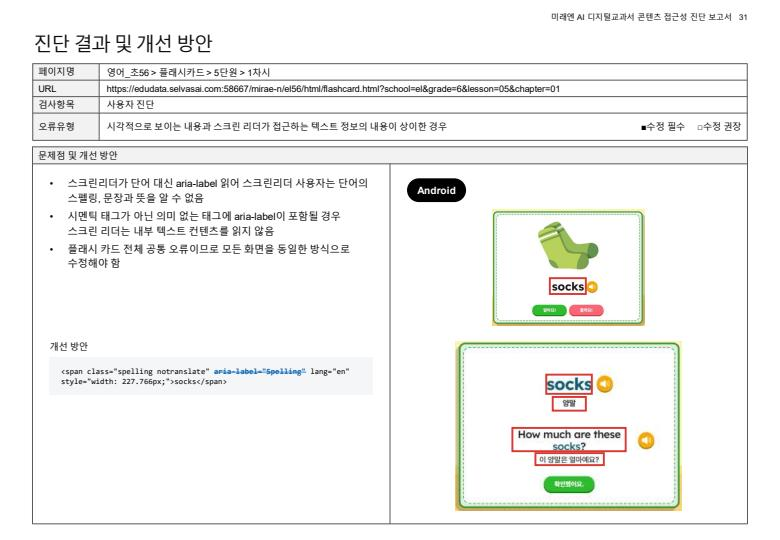

In [14]:
def plt_img_base64(img_base64):
    """
    Disply base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


plt_img_base64(results[4][0].page_content)

## RAG

In [15]:
# 중복된 이미지 처리
# === 추가 import ===
import io, hashlib
from PIL import Image
try:
    import imagehash
    HAS_IMAGEHASH = True
except Exception:
    HAS_IMAGEHASH = False

# === 헬퍼: base64 → bytes 해시 ===
def _sha1_of_b64(b64_str: str) -> str:
    try:
        raw = base64.b64decode(b64_str.split(",", 1)[-1], validate=False)
    except Exception:
        raw = base64.b64decode(b64_str)
    return hashlib.sha1(raw).hexdigest()

def _phash_of_b64(b64_str: str):
    if not HAS_IMAGEHASH:
        return None
    try:
        raw = base64.b64decode(b64_str.split(",", 1)[-1], validate=False)
    except Exception:
        raw = base64.b64decode(b64_str)
    im = Image.open(io.BytesIO(raw)).convert("RGB")
    return imagehash.phash(im)  # 64bit hash

# === (선택) 메타데이터 기반 동일문서 판정 ===
def _meta_key(doc):
    try:
        source = doc.metadata.get("source") or doc.metadata.get("file_path")
        page   = doc.metadata.get("page")
        return (source, page)
    except Exception:
        return None

# === 검색 결과 중복 제거: exact + near-duplicate + metadata ===
def dedup_results(results, phash_threshold: int = 6):
    """
    results: List[(Document, score)]
    return:  중복 제거된 results
    """
    # Document 타입 호환 import
    try:
        from langchain_core.documents import Document as _Doc
    except Exception:
        try:
            from langchain.schema import Document as _Doc
        except Exception:
            _Doc = None

    seen_sha, seen_meta, kept = set(), set(), []
    phash_list = []  # (phash, idx)
    for item in results:
        doc, score = item
        # base64 추출
        b64 = doc.page_content if (_Doc and isinstance(doc, _Doc)) else getattr(doc, "page_content", None)
        if not isinstance(b64, str):
            # 혹시 이미 b64 문자열이 아니라면 스킵
            continue

        # 1) metadata 동일 문서/페이지 제거
        mk = _meta_key(doc)
        if mk and mk in seen_meta:
            continue

        # 2) SHA-1 동일(완전 동일) 제거
        s = _sha1_of_b64(b64)
        if s in seen_sha:
            continue

        # 3) perceptual hash(유사 이미지) 제거
        is_near_dup = False
        ph = _phash_of_b64(b64) if HAS_IMAGEHASH else None
        if ph is not None:
            for prev_ph, _ in phash_list:
                if prev_ph - ph <= phash_threshold:
                    is_near_dup = True
                    break
        if is_near_dup:
            continue

        # keep
        kept.append((doc, score))
        seen_sha.add(s)
        if mk: seen_meta.add(mk)
        if ph is not None:
            phash_list.append((ph, len(kept)-1))

    return kept

# === b64 리스트 중복 제거 (VLM 투입 전 안전장치) ===
def dedup_b64_list(b64_list, phash_threshold: int = 6):
    out, seen_sha, ph_list = [], set(), []
    for b64 in b64_list:
        s = _sha1_of_b64(b64)
        if s in seen_sha:
            continue
        is_near = False
        ph = _phash_of_b64(b64) if HAS_IMAGEHASH else None
        if ph is not None:
            for p in ph_list:
                if p - ph <= phash_threshold:
                    is_near = True
                    break
        if is_near:
            continue
        out.append(b64)
        seen_sha.add(s)
        if ph is not None:
            ph_list.append(ph)
    return out


In [ ]:
from pathlib import Path
import base64
from typing import Any, List, Tuple

# LangChain / OpenAI
from langchain.schema import HumanMessage
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

########################################
# 0) 멀티모달 모델 (gpt-4o 권장)
########################################
model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=1024)

########################################
# 1) 유틸 함수들
########################################
def _encode_file_to_b64(uri: str) -> tuple[str, str]:
    """로컬 파일을 base64로 인코딩하여 (mime, b64) 반환"""
    ext = Path(uri).suffix.lower()
    mime = "image/jpeg"
    if ext == ".png": mime = "image/png"
    elif ext == ".webp": mime = "image/webp"
    elif ext == ".gif": mime = "image/gif"
    b64 = base64.b64encode(Path(uri).read_bytes()).decode("utf-8")
    return mime, b64

def prepare_images(docs_or_results: List[Any]) -> dict:
    """
    Prepare images for prompt.

    입력 지원:
      - [Document, Document, ...]
      - [(Document, score), (Document, score), ...]
    반환:
      - {"images": [base64, base64, ...]}
    """
    # Document 타입 호환 import
    try:
        from langchain_core.documents import Document as _Doc
    except Exception:
        try:
            from langchain.schema import Document as _Doc
        except Exception:
            _Doc = None

    b64_images = []
    for item in docs_or_results:
        doc = item
        if isinstance(item, (tuple, list)) and len(item) >= 1:
            doc = item[0]  # (Document, score) → Document
        if _Doc and isinstance(doc, _Doc):
            doc = doc.page_content  # base64 문자열
        b64_images.append(doc)
    return {"images": b64_images}

def img_prompt_func(data_dict, num_images: int = 3):
    """
    첫 번째: 현재 진단 이미지
    이후: RAG로 검색된 과거 유사 사례 이미지들
    3단 구성으로 간결 요약하도록 지시
    """
    messages = []

    # 현재 이미지 (uri 또는 b64)
    current_b64 = data_dict.get("current_image_b64")
    current_mime = data_dict.get("current_image_mime", "image/jpeg")
    if not current_b64 and data_dict.get("current_image_uri"):
        current_mime, current_b64 = _encode_file_to_b64(str(data_dict["current_image_uri"]))
    if current_b64:
        messages.append({
            "type": "image_url",
            "image_url": {"url": f"data:{current_mime};base64,{current_b64}"},
        })

    # 과거 사례 이미지들
    past_images = (data_dict.get("context") or {}).get("images", [])[:num_images]
    for b64 in past_images:
        messages.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{b64}"},
        })

    # 간결 3단 프롬프트
    text_prompt = (
        "당신은 접근성/UX 진단 보조 분석가입니다.\n"
        "첫 번째 이미지는 현재 진단 중인 페이지, 이후 이미지는 RAG로 검색된 과거 유사 사례입니다.\n\n"
        "출력은 반드시 딱 3줄로만 작성하세요:\n"
        "1) 과거 사례 요약 (사례명, 문제, 솔루션)\n"
        "2) 현재 페이지와 비교한 공통점/차이점 (간단 유사도 포함)\n"
        "3) 적용 가능성 판단과 핵심 개선 방향(P1~P3 요약)\n\n"
        "[주의] 'AI 에이전트:' 같은 접두어나 불필요한 장식은 쓰지 말 것. "
        "불확실한 내용은 '가능성'으로만 표기."
    )
    messages.append({"type": "text", "text": text_prompt})

    return [HumanMessage(content=messages)]

########################################
# 2) 체인 구성 (검색 → 정리 → 프롬프트 → 답변 + 이미지 동시 반환)
########################################
def build_multimodal_chain(vectorstore):
    """
    inputs:
      {"uri": "...", "k": 5, "num_images": 3, "oversample": 3}
    """

    def search_step(d: dict):
        uri = d["uri"]
        k = int(d.get("k", 5))
        oversample = int(d.get("oversample", 3))  # 중복 대비 넉넉히 가져오기
        raw_k = max(k * oversample, k)
        raw_results = vectorstore.similarity_search_by_image_with_relevance_score(
            uri=uri, k=raw_k
        )
        # 1) 검색 직후 중복 제거
        uniq_results = dedup_results(raw_results, phash_threshold=6)
        # 상위 k개만 유지
        uniq_results = uniq_results[:k]
        return {
            "uri": uri,
            "results": uniq_results,
            "question": d.get("question", ""),
            "num_images": d.get("num_images", min(k, 5)),
        }

    def prepare_step(d: dict):
        context = prepare_images(d["results"])   # {"images": [b64, ...]}
        # 2) VLM 투입 전 b64 리스트 중복 2차 제거(안전장치)
        context["images"] = dedup_b64_list(context["images"], phash_threshold=6)
        return {**d, "context": context}

    def attach_current_image(d: dict):
        mime, b64 = _encode_file_to_b64(d["uri"])
        return {**d, "current_image_mime": mime, "current_image_b64": b64}

    def generate_answer(d: dict):
        msgs = img_prompt_func(d, num_images=int(d.get("num_images", 3)))
        resp = model.invoke(msgs)  # AIMessage
        return resp.content

    chain = (
        RunnableLambda(search_step)
        | RunnableLambda(prepare_step)
        | RunnableLambda(attach_current_image)
        | {
            "answer": RunnableLambda(generate_answer),
            "current_image": RunnableLambda(lambda d: f"data:{d['current_image_mime']};base64,{d['current_image_b64']}"),
            "past_images": RunnableLambda(lambda d: d["context"]["images"]),
            "scores": RunnableLambda(lambda d: [float(s) for (_doc, s) in d["results"]]),
        }
    )
    return chain



In [25]:
# ====== Prettier display for Jupyter/Colab ======
import os, re, base64
from pathlib import Path
from IPython.display import display, HTML

def _to_data_url(obj, default_mime="image/jpeg"):
    """path | data URL | pure base64 -> data URL"""
    if obj is None:
        return None
    if isinstance(obj, str) and obj.startswith("data:"):
        return obj
    if isinstance(obj, (str, os.PathLike)) and os.path.exists(str(obj)):
        ext = Path(obj).suffix.lower()
        mime = "image/jpeg"
        if ext == ".png": mime = "image/png"
        elif ext == ".gif": mime = "image/gif"
        elif ext == ".webp": mime = "image/webp"
        data = Path(obj).read_bytes()
        b64 = base64.b64encode(data).decode("utf-8")
        return f"data:{mime};base64,{b64}"
    if isinstance(obj, str):
        return f"data:{default_mime};base64,{obj}"
    return None

def _md_to_html_light(md_text: str) -> str:
    """markdown 모듈이 없을 때 최소 변환(###, **bold**, 불릿)"""
    if not md_text:
        return ""
    # 헤더
    html = re.sub(r"^###\s*(.+)$", r"<h3>\1</h3>", md_text, flags=re.MULTILINE)
    # 볼드
    html = re.sub(r"\*\*(.+?)\*\*", r"<strong>\1</strong>", html)
    # 불릿을 <ul><li>로 변환
    lines = html.splitlines()
    out, in_ul = [], False
    for ln in lines:
        if re.match(r"^\s*-\s+", ln):
            if not in_ul:
                out.append("<ul>")
                in_ul = True
            out.append(f"<li>{re.sub(r'^\s*-\s+', '', ln)}</li>")
        else:
            if in_ul:
                out.append("</ul>")
                in_ul = False
            out.append(f"<p>{ln}</p>" if ln.strip() else "<p style='height:6px'></p>")
    if in_ul:
        out.append("</ul>")
    return "\n".join(out)

def _render_markdown(md_text: str) -> str:
    """markdown lib 있으면 사용, 없으면 라이트 변환"""
    try:
        import markdown
        return markdown.markdown(md_text, extensions=["extra", "sane_lists"])
    except Exception:
        return _md_to_html_light(md_text)

def show_rag_images_pretty(result_dict, max_past=6, dark=True):
    """
    result_dict:
      {
        "answer": "...",
        "current_image": <path | data URL | base64>,
        "past_images": [<b64 | dataurl>...],
        "scores": [float,...]
      }
    """
    curr = _to_data_url(result_dict.get("current_image"))
    past = result_dict.get("past_images") or []
    scores = result_dict.get("scores") or []

    theme_bg   = "#0b1220" if dark else "#f6f7fb"
    theme_card = "#0f172a" if dark else "#ffffff"
    theme_txt  = "#e5ecff" if dark else "#0f172a"
    theme_muted= "#9fb0d1" if dark else "#5b6785"
    theme_accent = "#22d3ee"

    # 이미지 카드들
    cards_html = ""
    if curr:
        cards_html += f"""
        <div class="card current">
          <div class="title">현재 진단 페이지</div>
          <img src="{curr}" />
        </div>"""

    for i, p in enumerate(past[:max_past]):
        p_url = _to_data_url(p)
        score_html = ""
        if i < len(scores):
            try:
                score_html = f"<div class='score'>score: {float(scores[i]):.3f}</div>"
            except Exception:
                pass
        cards_html += f"""
        <div class="card">
          <div class="title">과거 사례 #{i}</div>
          <img src="{p_url}" />
          {score_html}
        </div>"""

    # 요약(3단) — 마크다운을 HTML로
    summary_html = _render_markdown(result_dict.get("answer", ""))

    # 섹션을 카드처럼 보이게 래핑(###로 나뉜 블록에 스타일)
    # h3를 카드의 헤더로 삼고 이하 문단을 본문으로 감싸기
    def sectionize(html):
        parts = re.split(r"(<h3>.*?</h3>)", html)
        blocks = []
        current = []
        for part in parts:
            if part.startswith("<h3>"):
                if current:
                    blocks.append("".join(current))
                    current = []
                current.append(f"<div class='section'>{part}")
            else:
                current.append(part)
        if current:
            blocks.append("".join(current))
        # 섹션 닫기
        blocks = [b + "</div>" if not b.endswith("</div>") else b for b in blocks]
        return "\n".join(blocks)
    summary_html = sectionize(summary_html)

    html = f"""
    <style>
      .rag-wrap {{
        font-family: ui-sans-serif, -apple-system, Segoe UI, Roboto, Helvetica, Arial;
        color: {theme_txt};
        background:{theme_bg};
        padding: 16px 18px 28px;
        border-radius: 16px;
        border: 1px solid rgba(255,255,255,0.06);
      }}
      .grid {{
        display:grid;
        grid-template-columns: repeat(auto-fill, minmax(260px, 1fr));
        gap: 14px;
        margin-bottom: 18px;
      }}
      .card {{
        background:{theme_card};
        border:1px solid rgba(255,255,255,0.08);
        border-radius:16px;
        padding:12px;
        box-shadow: 0 10px 20px rgba(3,10,30,0.25);
      }}
      .card.current {{ outline: 2px dashed {theme_accent}; }}
      .card .title {{
        font-weight:700; margin:4px 2px 10px; letter-spacing:.2px;
      }}
      .card img {{
        width:100%; height:auto; border-radius:12px; display:block;
        background:#00000014;
      }}
      .card .score {{
        font-size:12px; color:{theme_muted}; margin-top:6px;
      }}

      .summary {{
        background:{theme_card};
        border:1px solid rgba(255,255,255,0.08);
        border-radius:16px;
        padding:16px 18px;
      }}
      .summary .header {{
        font-weight:800; letter-spacing:.3px; margin-bottom:10px;
        display:flex; align-items:center; gap:8px;
      }}
      .summary .header .dot {{
        width:8px; height:8px; border-radius:50%; background:{theme_accent};
        box-shadow:0 0 0 4px rgba(34,211,238,0.18);
      }}
      .summary .section {{
        border:1px solid rgba(255,255,255,0.08);
        border-radius:12px;
        padding:12px 14px; margin-top:12px;
        background:linear-gradient(180deg, rgba(255,255,255,0.02), rgba(255,255,255,0.01));
      }}
      .summary h3 {{ margin: 2px 0 8px; font-size:15px; }}
      .summary p  {{ color:{theme_muted}; margin:6px 0; line-height:1.5; }}
      .summary ul {{ margin:6px 0 6px 18px; color:{theme_muted}; }}
      .summary li {{ margin:4px 0; }}
      code, pre {{ background:rgba(255,255,255,0.06); padding:2px 6px; border-radius:6px; }}
    </style>

    <div class="rag-wrap">
      <div class="grid">{cards_html}</div>
      <div class="summary">
        <div class="header"><span class="dot"></span>AI 요약 (3단)</div>
        {summary_html}
      </div>
    </div>
    """
    display(HTML(html))



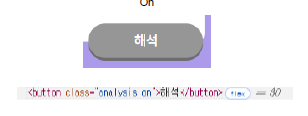
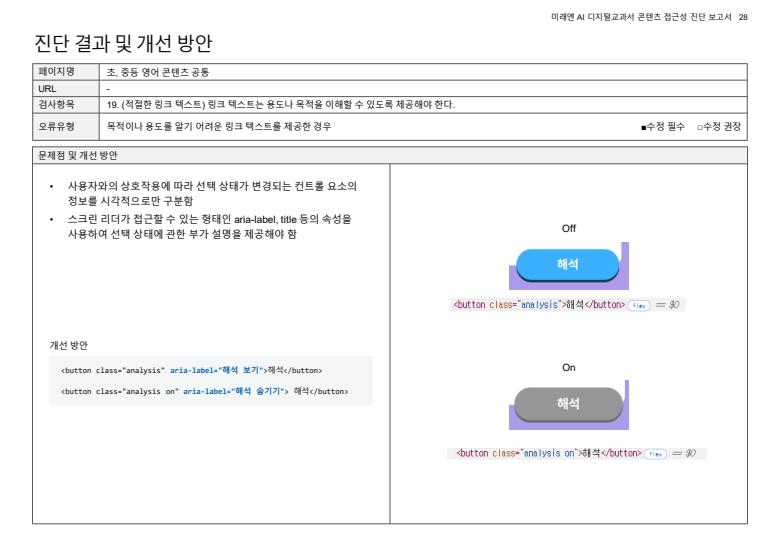

In [27]:
chain = build_multimodal_chain(vectorstore_mmembd)

res = chain.invoke({
    "uri": str(Path(r"C:/Doo/Multimodal_RAG/example.png")),
    "k": 50, "num_images": 50, "oversample": 3,
})

# 예쁜 렌더
show_rag_images_pretty(res, max_past=6, dark=True)
